In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv(os.path.join('HSM','stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume', 'OpenInt'])

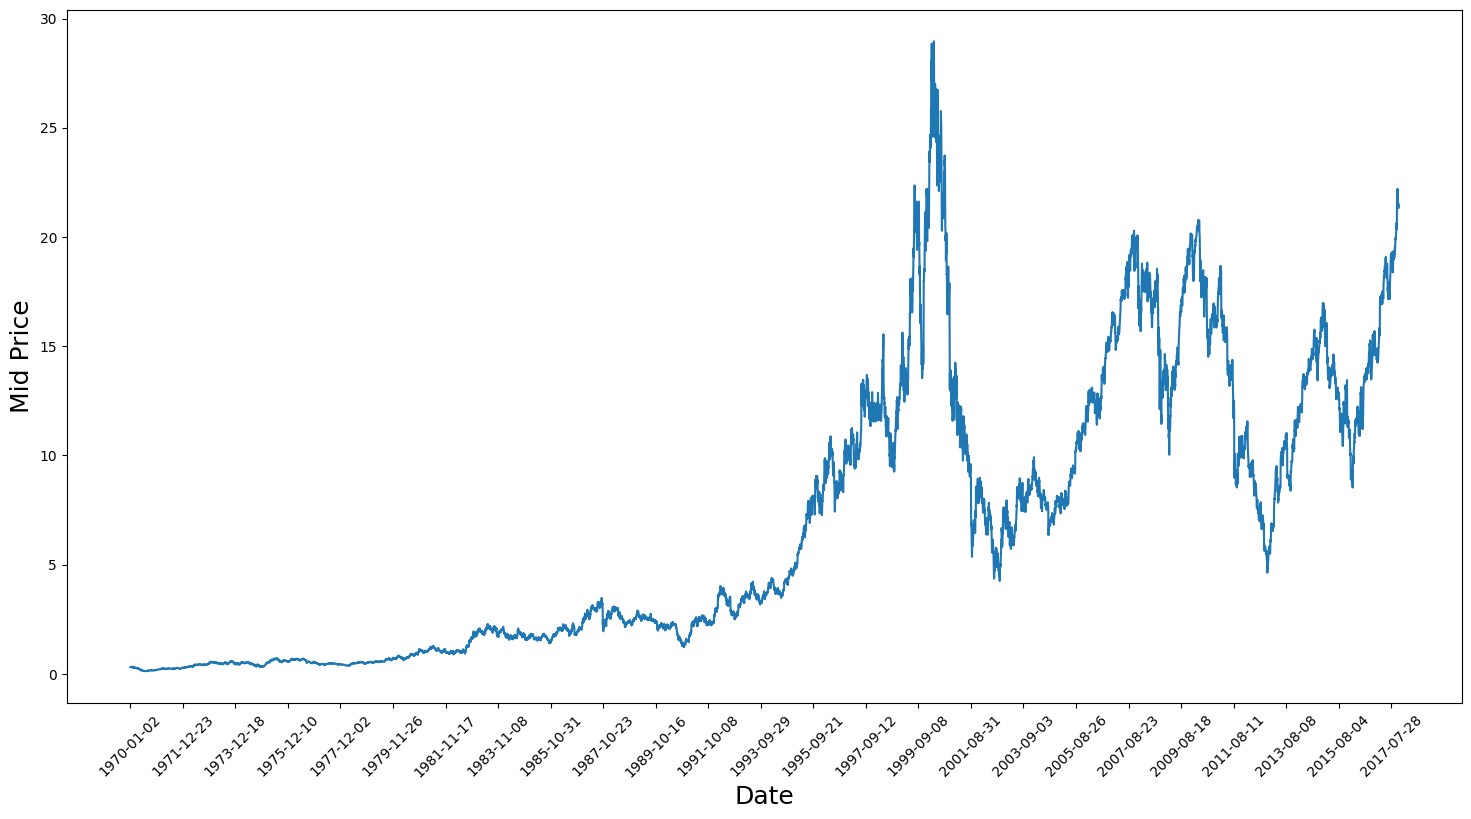

In [20]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [14]:
df = df.sort_values("Date").reset_index(drop=True)

# Retorno en 5 días
df["return_5"] = df["Close"].shift(-5) / df["Close"] - 1

# Target: 0=Sell, 1=Hold, 2=Buy
df["target"] = 1  # Hold por defecto
df.loc[df["return_5"] > 0.01, "target"] = 2  # Buy si sube más de +1%
df.loc[df["return_5"] < -0.01, "target"] = 0  # Sell si baja más de -1%

df = df.dropna().reset_index(drop=True)

# Features OHLCV
FEATURES = ["Open", "High", "Low", "Close", "Volume"]
X = df[FEATURES].values
y = df["target"].values

# Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
def create_sequences(X, y, window=50):
    xs, ys = [], []
    for i in range(len(X)-window):
        xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(xs), np.array(ys)

WINDOW = 50
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW)

# Split temporal
split = int(len(X_seq)*0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# One-hot encoding de las clases
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [16]:
tf.random.set_seed(42)

model = models.Sequential([
    layers.Input(shape=(WINDOW, X_seq.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(3, activation="softmax")  # 👈 3 clases
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)


Epoch 1/50
301/301 - 10s - 32ms/step - accuracy: 0.4160 - loss: 1.0540 - val_accuracy: 0.4210 - val_loss: 1.0834
Epoch 2/50
301/301 - 6s - 19ms/step - accuracy: 0.4240 - loss: 1.0500 - val_accuracy: 0.4210 - val_loss: 1.0777
Epoch 3/50
301/301 - 7s - 23ms/step - accuracy: 0.4228 - loss: 1.0502 - val_accuracy: 0.4210 - val_loss: 1.0784
Epoch 4/50
301/301 - 9s - 29ms/step - accuracy: 0.4233 - loss: 1.0492 - val_accuracy: 0.4210 - val_loss: 1.0776
Epoch 5/50
301/301 - 8s - 27ms/step - accuracy: 0.4260 - loss: 1.0491 - val_accuracy: 0.4210 - val_loss: 1.0760
Epoch 6/50
301/301 - 8s - 27ms/step - accuracy: 0.4277 - loss: 1.0482 - val_accuracy: 0.4210 - val_loss: 1.0759
Epoch 7/50
301/301 - 9s - 31ms/step - accuracy: 0.4296 - loss: 1.0489 - val_accuracy: 0.4210 - val_loss: 1.0753
Epoch 8/50
301/301 - 8s - 26ms/step - accuracy: 0.4292 - loss: 1.0483 - val_accuracy: 0.4210 - val_loss: 1.0766
Epoch 9/50
301/301 - 8s - 27ms/step - accuracy: 0.4291 - loss: 1.0482 - val_accuracy: 0.4210 - val_loss

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Classification Report:
              precision    recall  f1-score   support

        Sell       0.00      0.00      0.00       845
        Hold       0.00      0.00      0.00       547
         Buy       0.42      1.00      0.59      1012

    accuracy                           0.42      2404
   macro avg       0.14      0.33      0.20      2404
weighted avg       0.18      0.42      0.25      2404



c:\Users\Alejandro\Documents\GitHub\ML-StockMarket\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alejandro\Documents\GitHub\ML-StockMarket\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Alejandro\Documents\GitHub\ML-StockMarket\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

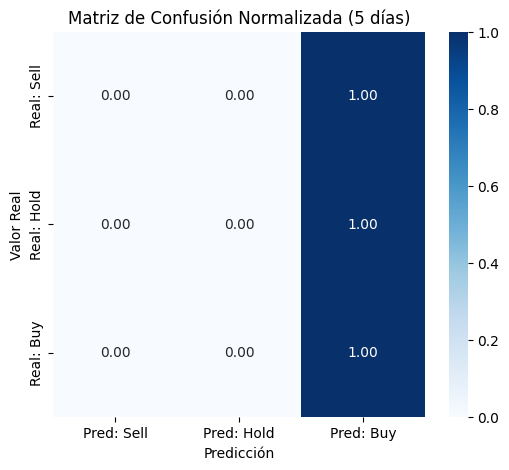

In [18]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Sell","Hold","Buy"]))

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Pred: Sell","Pred: Hold","Pred: Buy"],
            yticklabels=["Real: Sell","Real: Hold","Real: Buy"])
plt.title("Matriz de Confusión Normalizada (5 días)")
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.show()

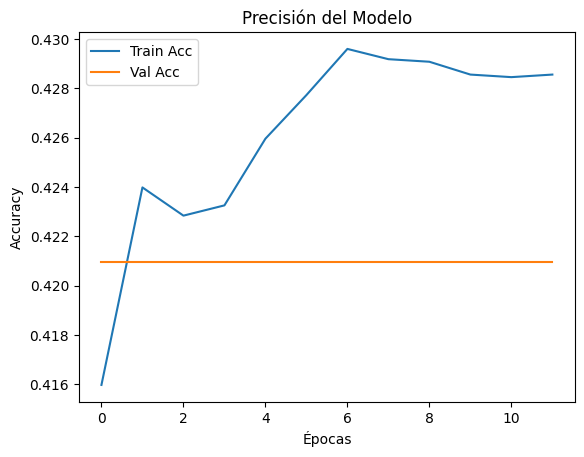

In [19]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Precisión del Modelo")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.show()